In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
def printMetrics(test, pred): 
    cm = confusion_matrix(test,pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cm_display.plot()
    print(f"accuracy: {accuracy_score(test, pred)}")
    print(f"f1_score: {f1_score(test, pred)}")
    print(f"precision_score: {precision_score(test, pred)}")
    print(f"recall: {recall_score(test, pred)}")
    print(f"roc_auc:{roc_auc_score(test,pred)}")

In [21]:
df = pd.read_csv("datasource/bank_data_after_fe.csv")

In [22]:
target_value = "y"

In [23]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=target_value),
    df[target_value],
    test_size=0.2,
    stratify=df[target_value],
    random_state=42,
)

### Be carefull. Do not run all cells at once. Maybe, you do not need to run all calculations once more. Some of them take some time to process.

# Decision tree

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import poisson

In [7]:
model = DecisionTreeClassifier()

param_grid = {"criterion": ["gini", "log_loss", "entropy"],
              "class_weight": [None, "balanced"],
              "max_depth": poisson(6),
              "max_features": [None,"sqrt", "log2"],
              "min_samples_split": poisson(20),
              "min_samples_leaf": poisson(6)}

In [8]:
random = RandomizedSearchCV(estimator=model, 
                            param_distributions=param_grid, 
                            cv = 3, 
                            n_jobs=-1, 
                            random_state=42, 
                            scoring=['roc_auc','f1'],
                            refit='f1')

In [9]:
random_result = random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.456664 using {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 15}


accuracy: 0.7969613259668509
f1_score: 0.4878048780487805
precision_score: 0.3431372549019608
recall: 0.8433734939759037
roc_auc:0.8171625660207131


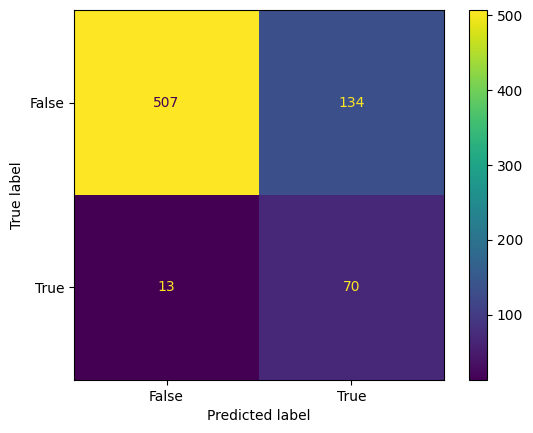

In [10]:
y_hat = random_result.best_estimator_.predict(X_test)
printMetrics(y_test, y_hat)
best_tree = random_result.best_estimator_

# Logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint

In [12]:
model = LogisticRegression()

param_grid = {"max_iter": randint(50,1000),
              "solver":["liblinear"],
              "penalty":["l1","l2"],
              "C": uniform(0,4),
              "class_weight":['balanced', None],
              "intercept_scaling": uniform(0,10)}

In [13]:
random = RandomizedSearchCV(estimator=model, 
                            param_distributions=param_grid, 
                            cv = 5, 
                            n_jobs=-1, 
                            random_state=42, 
                            scoring=['roc_auc','f1'],
                            refit='f1')

In [14]:
random_result = random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.472298 using {'C': 1.49816047538945, 'class_weight': 'balanced', 'intercept_scaling': 1.834347898661638, 'max_iter': 121, 'penalty': 'l1', 'solver': 'liblinear'}


accuracy: 0.8107734806629834
f1_score: 0.519298245614035
precision_score: 0.36633663366336633
recall: 0.891566265060241
roc_auc:0.8459391387703701


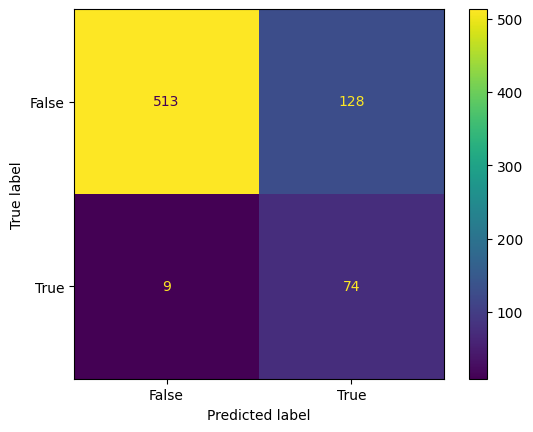

In [15]:
y_hat = random_result.best_estimator_.predict(X_test)
printMetrics(y_test, y_hat)
best_lr = random_result.best_estimator_

# SVC

Best: 0.460847 using {'class_weight': 'balanced', 'coef0': -0.6334729623490836, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 'auto', 'kernel': 'linear', 'shrinking': False}
accuracy: 0.8011049723756906
f1_score: 0.503448275862069
precision_score: 0.3526570048309179
recall: 0.8795180722891566
roc_auc:0.8352348551773395


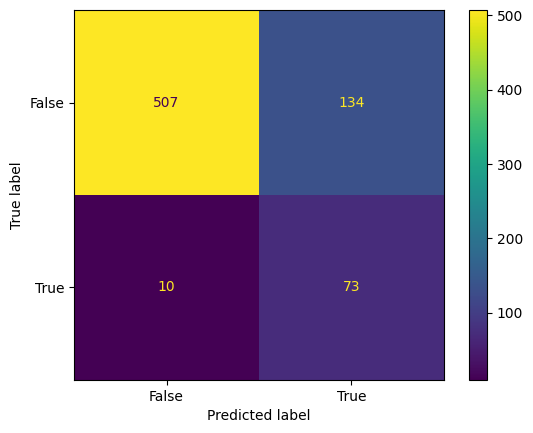

In [16]:
from sklearn.svm import SVC
from scipy.stats import uniform, randint

model = SVC()

param_grid = {"class_weight": ["balanced",None],
              "kernel": ["linear","poly","rbf","sigmoid"],
              "degree": poisson(3),
              "coef0": uniform(-2,2),
              "gamma": ["scale","auto"],
              "shrinking": [True,False],
              "decision_function_shape": ["ovo","ovr"]}

random = RandomizedSearchCV(estimator=model, 
                            param_distributions=param_grid, 
                            cv = 5, 
                            n_jobs=-1, 
                            random_state=42, 
                            scoring=['roc_auc','f1'],
                            refit='f1') #verbose = True #can be applied for long calculations (this one is long)

random_result = random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

y_hat = random_result.best_estimator_.predict(X_test)
printMetrics(y_test, y_hat)
best_svc = random_result.best_estimator_

# Gradient boosting

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best: 0.870462 using {'init': None, 'learning_rate': 2.1762942146834114, 'loss': 'exponential', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 22, 'n_estimators': 719, 'subsample': 1}
accuracy: 0.8825966850828729
f1_score: 0.3511450381679389
precision_score: 0.4791666666666667
recall: 0.27710843373493976
roc_auc:0.6190534368362686


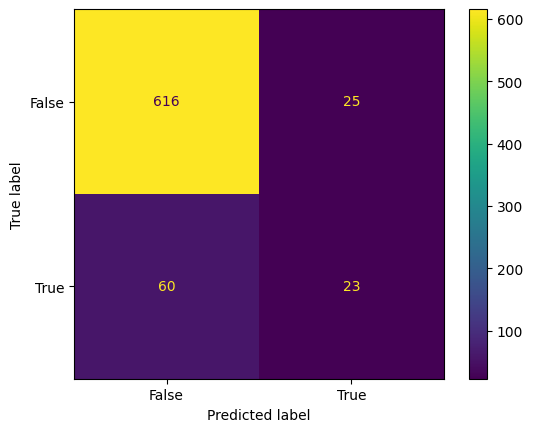

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint, expon

model = GradientBoostingClassifier()

param_grid = {"loss":["log_loss","exponential"],
              "learning_rate":expon(2),
              "n_estimators":randint(50,1000),
              "subsample":[0.01,0.1,0.2,0.5,0.8,1],
              "max_depth": poisson(6),
              "max_features": [None,"sqrt", "log2"],
              "min_samples_split": poisson(20),
              "min_samples_leaf": poisson(6),
              "init":[None,DummyClassifier(strategy="stratified"), best_lr, LogisticRegression(solver="liblinear", penalty='l1')]}
                      
random = RandomizedSearchCV(estimator=model, 
                            param_distributions=param_grid, 
                            cv = 3, 
                            n_jobs=-1, 
                            n_iter=50,
                            random_state=42, 
                            scoring=['recall','roc_auc'],
                            refit='roc_auc',
                            verbose=True) #verbose = True #can be applied for long calculations (this one is long)

random_result = random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

y_hat = random_result.best_estimator_.predict(X_test)
printMetrics(y_test, y_hat)
best_gb = random_result.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/krzysztof

Best: 0.526940 using {'init': LogisticRegression(C=1.49816047538945, class_weight='balanced',
                   intercept_scaling=1.834347898661638, max_iter=121,
                   penalty='l1', solver='liblinear'), 'learning_rate': 2.12431461585778, 'loss': 'exponential', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 25, 'n_estimators': 745, 'subsample': 0.8}
accuracy: 0.8839779005524862
f1_score: 0.45454545454545453
precision_score: 0.49295774647887325
recall: 0.42168674698795183
roc_auc:0.6827622502490461


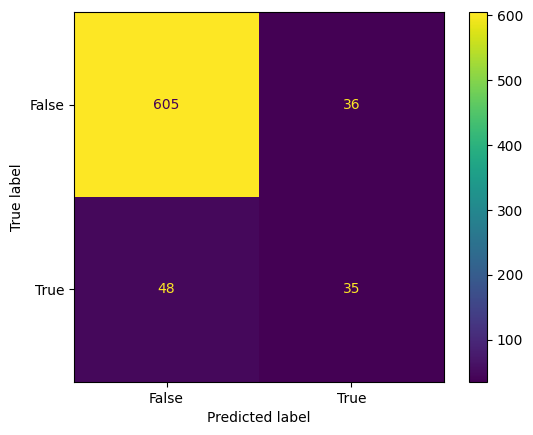

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint, expon

model = GradientBoostingClassifier()

param_grid = {"loss":["log_loss","exponential"],
              "learning_rate":expon(2),
              "n_estimators":randint(50,1000),
              "subsample":[0.01,0.1,0.2,0.5,0.8,1],
              "max_depth": poisson(6),
              "max_features": [None,"sqrt", "log2"],
              "min_samples_split": poisson(20),
              "min_samples_leaf": poisson(6),
              "init":[None,DummyClassifier(strategy="stratified"), best_lr, LogisticRegression(solver="liblinear", penalty='l1')]}
                      
random = RandomizedSearchCV(estimator=model, 
                            param_distributions=param_grid, 
                            cv = 3, 
                            n_jobs=-1, 
                            n_iter=50,
                            random_state=42, 
                            scoring=['recall','precision'],
                            refit='precision',
                            verbose=True) #verbose = True #can be applied for long calculations (this one is long)

random_result = random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

y_hat = random_result.best_estimator_.predict(X_test)
printMetrics(y_test, y_hat)
best_gb = random_result.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/krzysztof

Best: 0.469016 using {'init': LogisticRegression(C=1.49816047538945, class_weight='balanced',
                   intercept_scaling=1.834347898661638, max_iter=121,
                   penalty='l1', solver='liblinear'), 'learning_rate': 2.679294883716514, 'loss': 'exponential', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 19, 'n_estimators': 243, 'subsample': 0.8}
accuracy: 0.8895027624309392
f1_score: 0.47368421052631576
precision_score: 0.5217391304347826
recall: 0.43373493975903615
roc_auc:0.6911264402383325


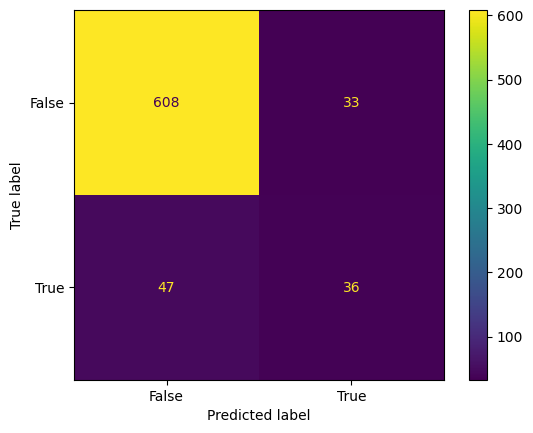

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint, expon

model = GradientBoostingClassifier()

param_grid = {"loss":["log_loss","exponential"],
              "learning_rate":expon(2),
              "n_estimators":randint(50,1000),
              "subsample":[0.01,0.1,0.2,0.5,0.8,1],
              "max_depth": poisson(6),
              "max_features": [None,"sqrt", "log2"],
              "min_samples_split": poisson(20),
              "min_samples_leaf": poisson(6),
              "init":[None,DummyClassifier(strategy="stratified"), best_lr, LogisticRegression(solver="liblinear", penalty='l1')]}
                      
random = RandomizedSearchCV(estimator=model, 
                            param_distributions=param_grid, 
                            cv = 3, 
                            n_jobs=-1, 
                            n_iter=50,
                            random_state=42, 
                            scoring=['recall','precision', 'f1'],
                            refit='f1',
                            verbose=True) #verbose = True #can be applied for long calculations (this one is long)

random_result = random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

y_hat = random_result.best_estimator_.predict(X_test)
printMetrics(y_test, y_hat)
best_gb = random_result.best_estimator_

# Random forest classifier

In [20]:
df.columns

Index(['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'day_of_the_year', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown'],
      dtype='object')

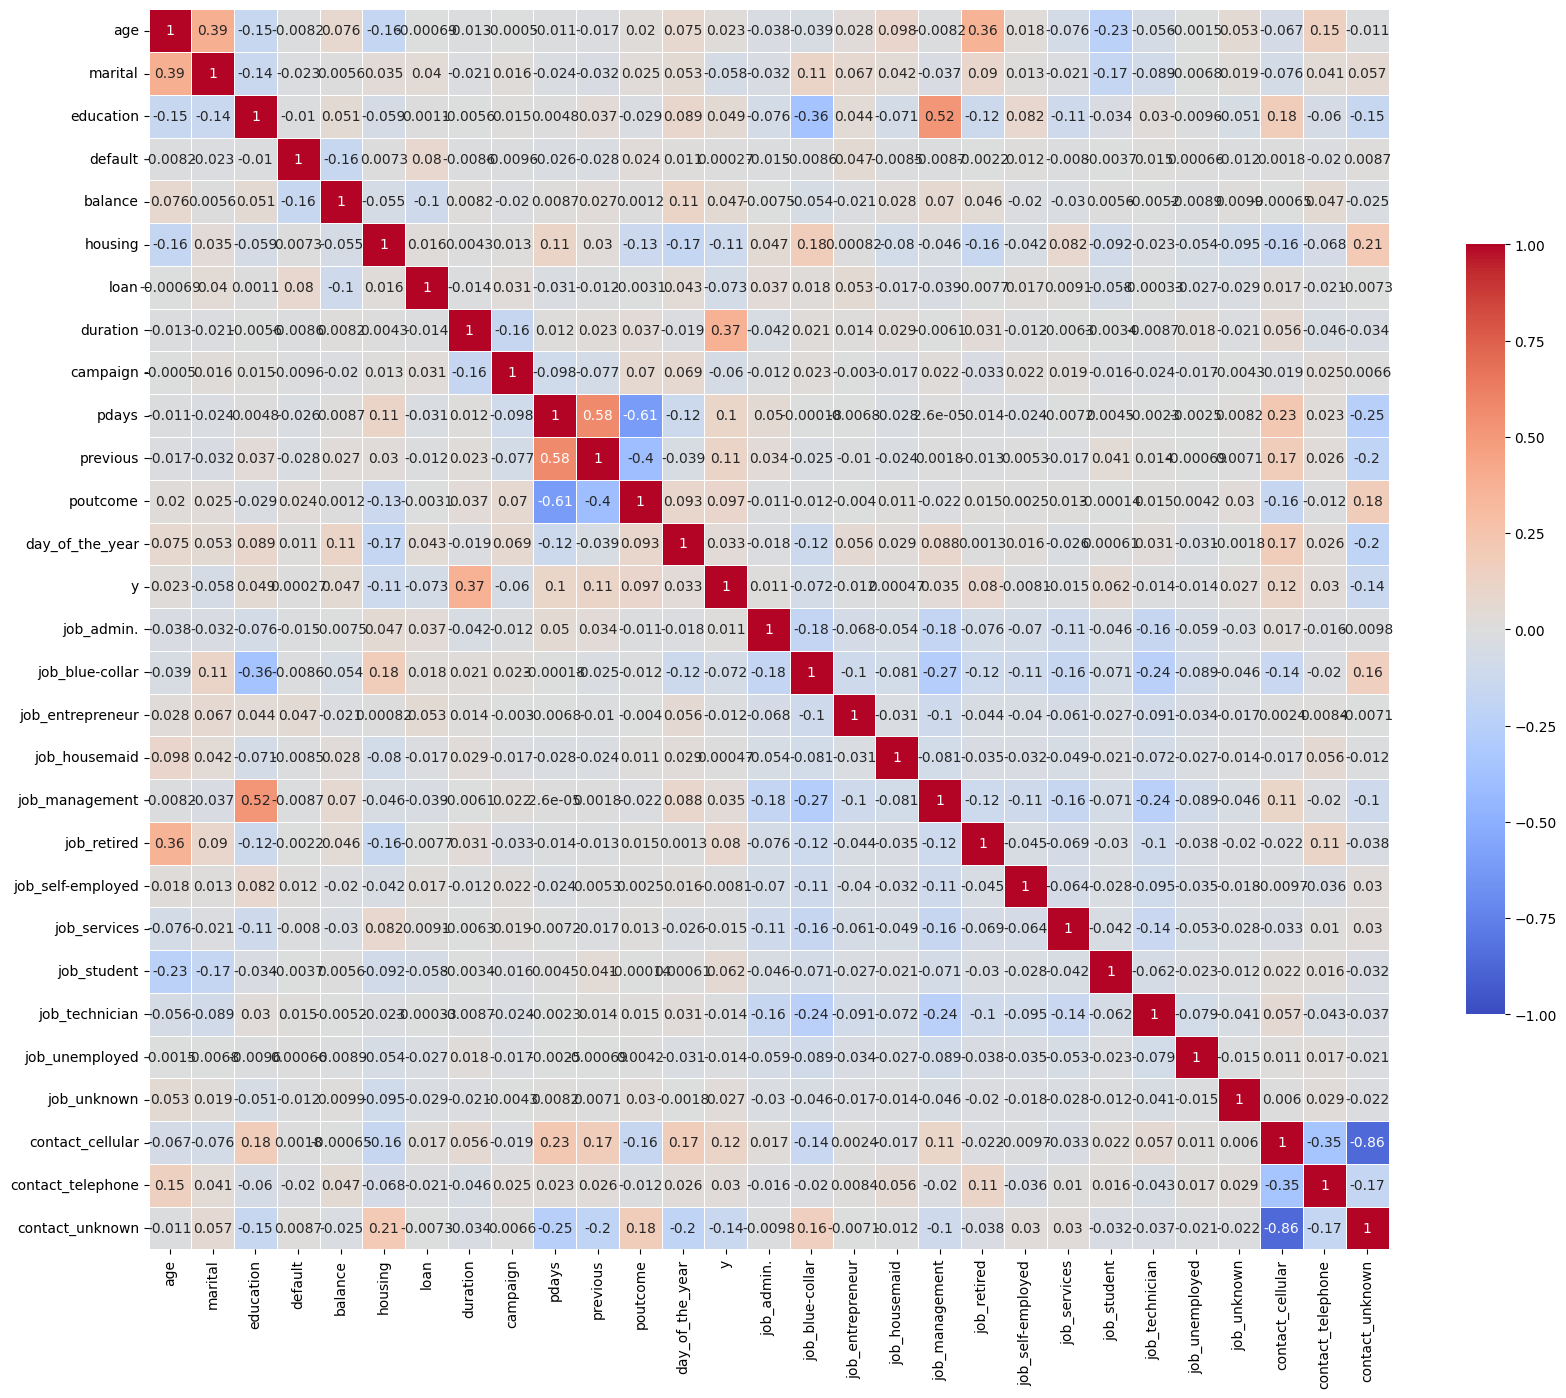

In [21]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [22]:
monotonic_dict= {}
for c in df.drop(columns='y').columns:
    monotonic_dict[c] = 0

monotonic_dict["duration"] = 1
monotonic_dict["job_housemaid"] = 1
monotonic_dict["job_entrepreneur"] = 1
monotonic_dict["job_admin."] = 1
monotonic_dict["job_retired"] = 1
monotonic_dict["job_management"] = 1
monotonic_dict["job_student"] = 1
monotonic_dict["job_unemployed"] = 1

monotonic_dict["job_unknown"] = -1



In [23]:
print(monotonic_dict.values())
print(X_train.columns)

dict_values([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, -1, 0, 0, 0])
Index(['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'day_of_the_year', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown'],
      dtype='object')


In [24]:
print(X_train.shape[1])
print(len(monotonic_dict))

28
28


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_c

Best: 0.554354 using {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 17, 'monotonic_cst': None, 'oob_score': <function roc_auc_score at 0x7f8892af7550>}
accuracy: 0.856353591160221
f1_score: 0.5478260869565217
precision_score: 0.42857142857142855
recall: 0.7590361445783133
roc_auc:0.8139954513843205


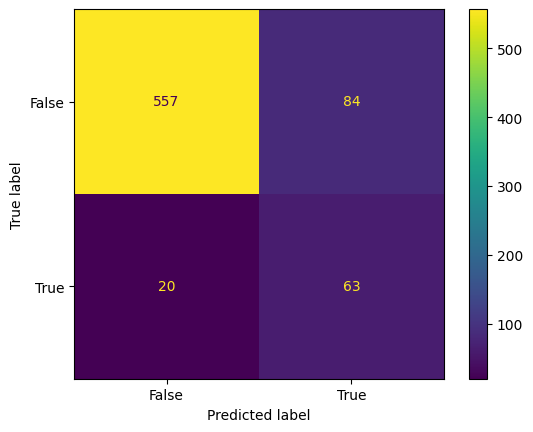

In [25]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

param_grid = {"criterion": ["gini", "log_loss", "entropy"],
              "class_weight": [None, "balanced", "balanced_subsample"],
              "max_depth": poisson(6),
              "max_features": [None,"sqrt", "log2"],
              "min_samples_split": poisson(20),
              "min_samples_leaf": poisson(6),
              "oob_score":[False, f1_score, recall_score, roc_auc_score],
              "monotonic_cst":[None, list(monotonic_dict.values())]}
                      
random = RandomizedSearchCV(estimator=model, 
                            param_distributions=param_grid, 
                            cv = 3, 
                            n_jobs=-1, 
                            n_iter=100,
                            random_state=41, 
                            scoring=['accuracy','f1'],
                            refit='f1',
                            verbose=True) #verbose = True #can be applied for long calculations (this one is long)

random_result = random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

y_hat = random_result.best_estimator_.predict(X_test)
printMetrics(y_test, y_hat)
best_rf = random_result.best_estimator_

# XGBClasifier

## gbtree

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
6 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/Users/krzysztof/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/Users

Best: 0.575905 using {'booster': 'gbtree', 'eta': 0.10987358313376537, 'max_delta_step': 1.446953199095078, 'max_depth': 4, 'min_child_weight': 1.666061864206202, 'objective': 'binary:logistic', 'scale_pos_weight': 7.671462829736211, 'tree_method': 'exact'}
accuracy: 0.8687845303867403
f1_score: 0.5777777777777777
precision_score: 0.45774647887323944
recall: 0.7831325301204819
roc_auc:0.8315038625641411


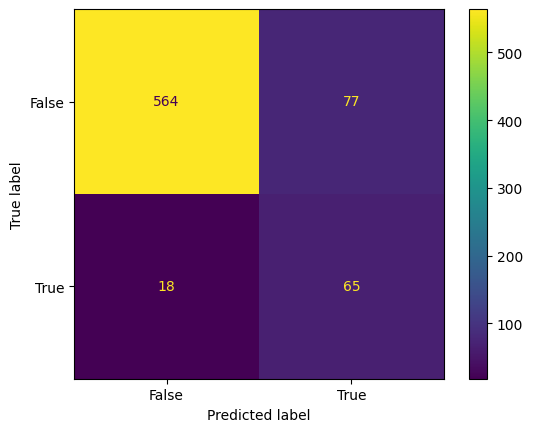

In [46]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import gamma, poisson, uniform

model = XGBClassifier()

positive = df.y.sum()
negative = df.y.count() - positive

param_grid = {"booster": ['gbtree'],
              "eta": gamma(a = 3, scale=0.1),
              "max_depth":poisson(6),
              "min_child_weight":uniform(0,2),
              "max_delta_step":uniform(0,10),
              "tree_method":["exact"],
              "scale_pos_weight":[1,negative/positive],
              "objective":["binary:logistic"]}
                      
random = RandomizedSearchCV(estimator=model, 
                            param_distributions=param_grid, 
                            cv = 3, 
                            n_jobs=-1, 
                            n_iter=200,
                            random_state=41, 
                            scoring=['accuracy','f1'],
                            refit='f1',
                            verbose=True) #verbose = True #can be applied for long calculations (this one is long)

random_result = random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

y_hat = random_result.best_estimator_.predict(X_test)
printMetrics(y_test, y_hat)
best_rf = random_result.best_estimator_

## gblinear

# Estimators! Assemble!

In [ ]:
best_tree = DecisionTreeClassifier(class_weight = 'balanced',
                                    criterion = 'log_loss', 
                                    max_depth= 11, 
                                    max_features = None, 
                                    min_samples_leaf = 4, 
                                    min_samples_split= 15)
best_lr = LogisticRegression(C= 1.49816047538945, 
                             class_weight= 'balanced',
                             intercept_scaling= 1.834347898661638,
                             max_iter= 121,
                             penalty= 'l1',
                             solver= 'liblinear')
best_svc = SVC(class_weight= 'balanced', 
               coef0= -0.6334729623490836, 
               decision_function_shape= 'ovr', 
               degree= 1, 
               gamma= 'auto', 
               kernel= 'linear', 
               shrinking= False) 
best_gb = GradientBoostingClassifier(init=best_lr, 
                                     learning_rate= 2.679294883716514,
                                     loss= 'exponential', 
                                     max_depth= 7,
                                     max_features= 'sqrt', 
                                     min_samples_leaf= 12, 
                                     min_samples_split= 19, 
                                     n_estimators= 243, 
                                     subsample= 0.8)
best_rf = RandomForestClassifier(class_weight = 'balanced_subsample',
                                 criterion = 'entropy',
                                 max_depth = 10,
                                 max_features = 'sqrt',
                                 min_samples_leaf = 3,
                                 min_samples_split = 17,
                                 oob_score = True)
best_xgb = XGBClassifier(booster= 'gbtree', 
                         eta= 0.10987358313376537,
                         max_delta_step= 1.446953199095078, 
                         max_depth= 4, 
                         min_child_weight= 1.666061864206202, 
                         objective= 'binary:logistic', 
                         scale_pos_weight= 7.671462829736211, 
                         tree_method= 'exact')

accuracy: 0.8867403314917127
f1_score: 0.5858585858585859
precision_score: 0.5043478260869565
recall: 0.6987951807228916
roc_auc:0.8049358118903069


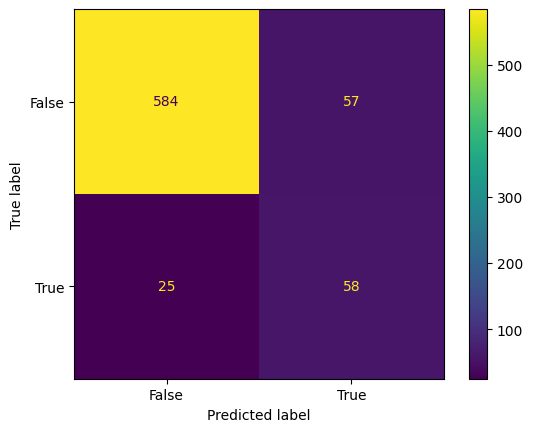

In [26]:
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(estimators=[("tree", best_tree),
                                     ("lr", best_lr),
                                     ("gradient",best_gb),
                                     ("rf", best_rf),
                                     ("svc", best_svc)], 
                         final_estimator=LogisticRegression(solver="liblinear", penalty="l1", class_weight={0:1, 1:2.6}),
                         cv = 3)#1,2
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
printMetrics(y_test, y_hat)